In [1]:
import string

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_erosion
import seaborn as sns
import torch

from scnn.sh import n_coeffs, spherical_harmonic
from scnn.models import SCNNModel

sns.set_theme()

if torch.cuda.is_available():
    device = "cuda"
    print(torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
else:
    raise Exception("CUDA not available")

BATCH_SIZE = int(5e2)

NVIDIA RTX A1000 6GB Laptop GPU


In [2]:
# Data and acquisition protocol

data_img = nib.load("../data/mri/preprocessed/sub-07/dwi.nii.gz")
data = data_img.get_fdata()
affine = data_img.affine
mask = binary_erosion(
    nib.load("../data/mri/preprocessed/sub-07/brain_mask.nii.gz")
    .get_fdata()
    .astype(bool),
    iterations=2,
)

bvals = torch.round(
    torch.tensor(np.loadtxt("../data/mri/preprocessed/sub-07/dwi.bval") / 1e3),
    decimals=1,
).float()
bvecs = torch.tensor(np.loadtxt("../data/mri/preprocessed/sub-07/dwi.bvec").T).float()
bvecs[:, 0] *= -1

data /= np.mean(data[..., np.where(bvals == 0)[0]], axis=-1)[..., np.newaxis]

idx = bvals > 0
data = data[..., idx]
bvals = bvals[idx]
bvecs = bvecs[idx]

bs = torch.unique(bvals)
n_shells = len(bs)
shell_indices = [torch.where(bvals == b)[0] for b in bs]

bvecs_isft_per_shell = []
bvecs_sft_per_shell = []
for idx in shell_indices:
    shell_bvecs = bvecs[idx]
    thetas = torch.arccos(shell_bvecs[:, 2])
    phis = (torch.arctan2(shell_bvecs[:, 1], shell_bvecs[:, 0]) + 2 * np.pi) % (
        2 * np.pi
    )
    bvecs_isft = torch.zeros(len(shell_bvecs), 45)
    for l in range(0, 8 + 1, 2):
        for m in range(-l, l + 1):
            bvecs_isft[:, int(0.5 * l * (l + 1) + m)] = spherical_harmonic(
                l, m, thetas, phis
            )
    bvecs_isft_per_shell.append(bvecs_isft)
    bvecs_sft = torch.zeros((45, len(shell_bvecs)), dtype=float)
    bvecs_sft[0:45] = (
        torch.linalg.pinv(bvecs_isft[:, 0:45].T @ bvecs_isft[:, 0:45])
        @ bvecs_isft[:, 0:45].T
    )
    bvecs_sft_per_shell.append(bvecs_sft.float())

/tmp/ipykernel_27388/1194942619.py:20: RuntimeWarning: invalid value encountered in divide
  data /= np.mean(data[..., np.where(bvals == 0)[0]], axis=-1)[..., np.newaxis]


In [3]:
# Load model and make the forward passes

model = SCNNModel(2, 2).to(device)
model.load_state_dict(torch.load("../scnn_weights_rot.pt"))
model.eval()

signals = torch.tensor(data[mask]).float()
signals_sh = torch.zeros(len(signals), n_shells, 45)
for i, idx in enumerate(shell_indices):
    signals_sh[:, i] = (bvecs_sft_per_shell[i] @ signals[:, idx].unsqueeze(-1)).squeeze(
        -1
    )

preds = torch.zeros(len(signals_sh), 47)
with torch.no_grad():
    for i in range(0, len(signals_sh), BATCH_SIZE):
        print(f"{int(100 * i / len(signals_sh))}%", end="\r")
        if i + BATCH_SIZE <= len(signals_sh):
            idx = torch.arange(i, i + BATCH_SIZE)
        else:
            idx = torch.arange(i, len(signals_sh))
        preds[idx] = model(
            torch.nn.functional.pad(signals_sh[idx], (0, n_coeffs - 45)).to(device)
        ).cpu()
print("100%")

params = np.zeros((mask.shape + (47,)))
params[mask] = preds

nib.save(nib.Nifti1Image(params[..., 45::], affine), "params.nii.gz")
nib.save(
    nib.Nifti1Image(params[..., 0:45] * params[..., 46:47].clip(0, 1), affine),
    "odfs.nii.gz",
)

100%


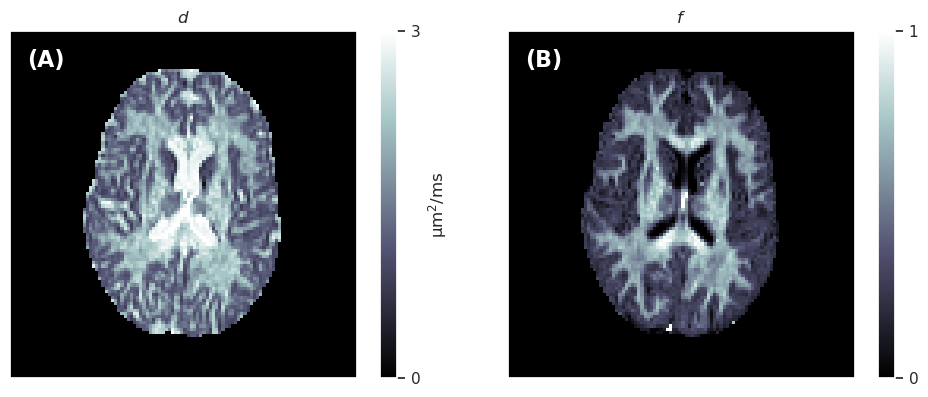

In [5]:
# Show the maps

z = 37

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

im = ax[0].imshow(np.rot90(params[..., z, -2]), vmin=0, vmax=3, cmap="bone")
cbar = plt.colorbar(im)
cbar.set_ticks([0, 3])
cbar.set_label(r"μm$^2$/ms")
ax[0].set_title(r"$d$")
ax[0].grid(False)
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(np.rot90(params[..., z, -1]), vmin=0, vmax=1, cmap="bone")
cbar = plt.colorbar(im)
cbar.set_ticks([0, 1])
ax[1].set_title(r"$f$")
ax[1].grid(False)
ax[1].set_xticks([])
ax[1].set_yticks([])

alphabet = list(string.ascii_uppercase)
for i in range(2):
    ax[i].text(
        0.05,
        0.95,
        f"({alphabet[i]})",
        transform=ax[i].transAxes,
        fontsize=16,
        verticalalignment="top",
        color="white",
        weight="bold",
    )

fig.tight_layout()
plt.show()

fig.savefig("2-compartment-model-maps.png")